# Summary

Demonstrate the various steps for indtroducing synthetic error in GCM data. This notebook demonstrates the process for mean seasonal temperature. The process for other meteorological variables is identical.

In [1]:
import pandas as pd
import xarray as xr
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.restoration import denoise_tv_chambolle, calibrate_denoiser
from skimage.restoration import denoise_invariant

from dirs import prepdir

In [3]:
## PRISM mask
interp_mask = np.load(prepdir + 'mask_prism_9km.npy')

cum_precip_gcm = xr.open_dataarray(prepdir + 'cum_precipBC_v2.nc')
cum_precip_snow_gcm = xr.open_dataarray(prepdir + 'cum_precip_snowBC_v2.nc')
seasonal_t2_gcm = xr.open_dataarray(prepdir + 'seasonal_t2BC_v2.nc') - 273.15
pdd_sum_gcm = xr.open_dataarray(prepdir + 'pdd_sumBC_v2.nc')

cum_precip_prism = xr.open_dataarray(prepdir + 'cum_precip_prism.nc')
cum_precip_snow_prism = xr.open_dataarray(prepdir + 'cum_precip_snow_prism.nc')
seasonal_t2_prism = xr.open_dataarray(prepdir + 'seasonal_t2_prism.nc') 
pdd_sum_prism = xr.open_dataarray(prepdir + 'pdd_sum_prism.nc')



## Basin masks
masks = xr.open_dataset(f'{prepdir}/basin_masks_filtered.nc')

# Denoising function

This is a very simple de-noiser with just one parameter <br>
https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_tv_chambolle <br>
https://scikit-image.org/docs/dev/auto_examples/filters/plot_j_invariant_tutorial.html


Default parameters of the denoiser do not necessarily give the best results. <br>
We need to calibrate the denoiser separately for each gcm output.

In [50]:
def get_denoised_res (res_copy):
    parameter_ranges_tv = {'weight': np.arange(0.01, 3, 0.01)}
    _, (parameters_tested_tv, losses_tv) = calibrate_denoiser(
                                        res_copy,
                                        denoise_tv_chambolle,
                                        denoise_parameters=parameter_ranges_tv,
                                        extra_output=True)


    best_parameters_tv = parameters_tested_tv[np.argmin(losses_tv)]
    denoised_calibrated_tv = denoise_invariant(res_copy, denoise_tv_chambolle,
                                               denoiser_kwargs=best_parameters_tv)
    denoised_default_tv = denoise_tv_chambolle(res_copy, **best_parameters_tv)

    # print (best_parameters_tv)

    denoised_res = denoised_default_tv
    if (mean_squared_error(res_copy, denoised_default_tv)) > (mean_squared_error(res_copy, denoised_calibrated_tv)):
        denoised_res = denoised_calibrated_tv
    
    return denoised_res

# Read in precip and t2 for gcm=0

In [4]:
for gcm_ind in range(0,1):
    precip_gcm = cum_precip_gcm.sel(time=range(1981,2011)).isel(gcm=gcm_ind).where(interp_mask)
    t2_gcm = seasonal_t2_gcm.sel(time=range(1981,2011)).isel(gcm=gcm_ind).where(interp_mask)

# Sample comparison for t2, year 1981, gcm=0

Text(0.5, 1.0, 'time=1981, PRISM')

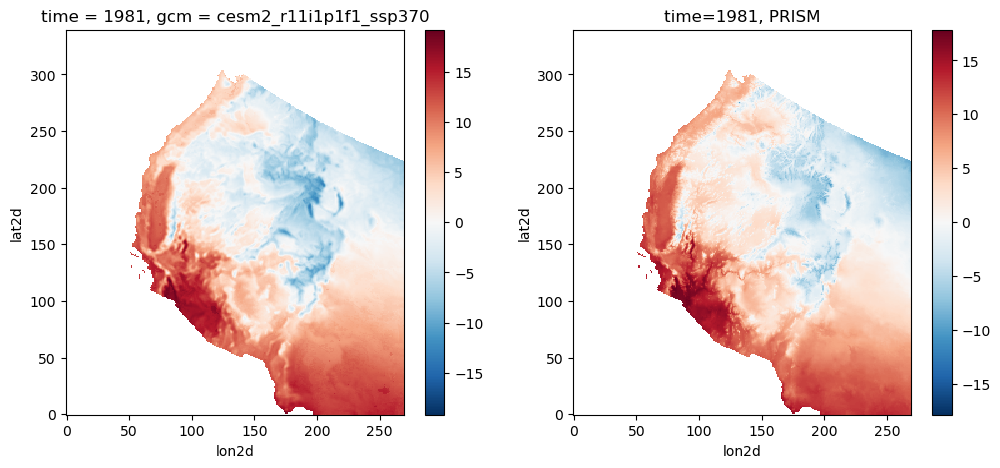

In [26]:
test_year = 1981
fig, ax = plt.subplots(1,2, figsize=(12,5))
t2_gcm.sel(time=test_year).plot(ax=ax[0])
seasonal_t2_prism.sel(time=test_year).plot(ax=ax[1])
ax[1].set_title(f'time={test_year}, PRISM')

### t2: Plot difference between prism and gcm (residue = prism - gcm)

Text(0.5, 1.0, 'time=1981, PRISM-gcm')

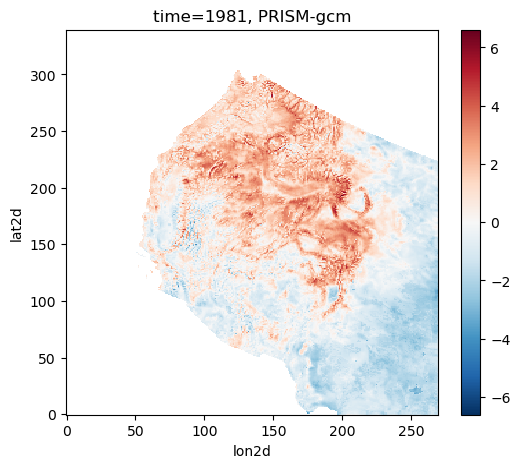

In [68]:
diff_t2 = seasonal_t2_prism - t2_gcm

fig, ax = plt.subplots(figsize=(6,5))

diff_t2 = seasonal_t2_prism - t2_gcm
diff_t2.sel(time=test_year).plot()
plt.title(f'time={test_year}, PRISM-gcm')

### t2: Get a per-pixel realization of synthetic error and add it to gcm

This is the initial synthetic error, which is noisy

In [ ]:
## Compute per-pixel mean and standard deviation of residue
mu = diff_t2.mean(axis=0)
stddev = diff_t2.std(axis=0, ddof=1)

In [69]:
rng = np.random.default_rng(seed=0)
res = rng.normal(loc=mu, scale=stddev, size=(30,340,270))

t2_mod = t2_gcm + res

### t2: Example de-noising for just one year (here, 1981)

Takes a few seconds. Just hang tight.

In [74]:
## This specifies the year
time_ind=0

In [71]:
### Convert masked nans to a constant value for the denoiser to work. 
### I like assigning the mean value of the field because it is roughly representative of the unmasked field
mu_time = np.nanmean(res, axis=(1,2), keepdims=True)
std_time = np.nanstd(res, axis=(1,2), keepdims=True)

res_normalized = (res - mu_time)/std_time
res_copy = np.copy(res_normalized[time_ind])
res_copy[~interp_mask]=np.nanmean(res_copy)

denoised_res = get_denoised_res(res_copy)
denoised_res = denoised_res*std_time[time_ind] + mu_time[time_ind]
denoised_res[~interp_mask] = np.nan

t2_mod_denoised = t2_gcm[time_ind] + denoised_res

Text(0.5, 1.0, 'time=1981, gcm + err + denoised')

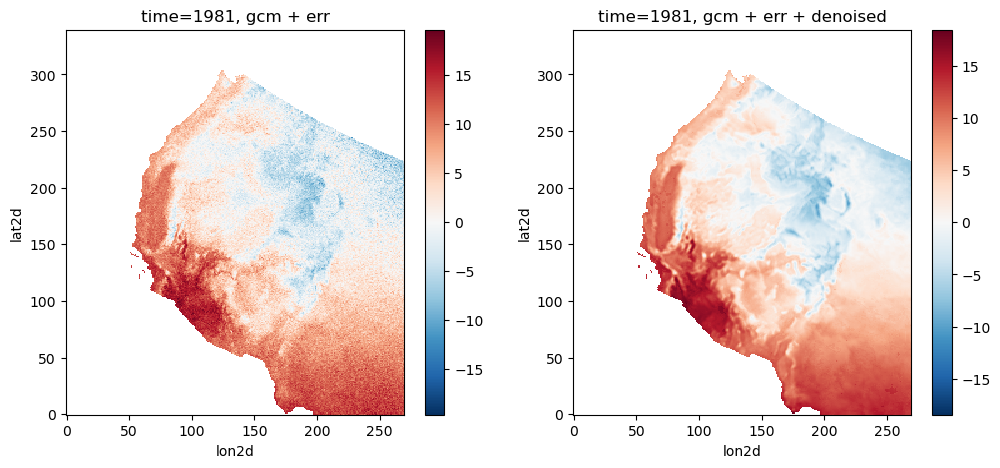

In [72]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

t2_mod.sel(time=test_year).plot(ax=ax[0])
ax[0].set_title(f'time={test_year}, gcm + err')

t2_mod_denoised.plot(ax=ax[1])
ax[1].set_title(f'time={test_year}, gcm + err + denoised')